1. Data Loading and Structure

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

In [ ]:
# !unzip /content/drive/MyDrive/UdS/SS2021/PracML/train.zip

In [ ]:
# !unzip /content/drive/MyDrive/UdS/SS2021/PracML/test.zip

In [ ]:
data_dir = '../content'
# print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['Dysplasia', 'Normal']


In [ ]:
dysplasia_files = os.listdir(data_dir + "/train/Dysplasia")
print('Number of training examples for Dysplasia:', len(dysplasia_files))
# print(dysplasia_files[:5])

Number of training examples for Dysplasia: 2500


In [ ]:
normal_files = os.listdir(data_dir + "/train/Normal")
print('Number of training examples for Normal:', len(normal_files))
# print(normal_files[:5])

Number of training examples for Normal: 2500


In [ ]:
# transform uniform images to tensors
dataset = ImageFolder(data_dir+'/train', transform=tt.Compose([tt.Resize(255),
                                tt.CenterCrop(224),
                                tt.ToTensor()
                                ]))

In [ ]:
# image size
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 0


Label:  Dysplasia (0)


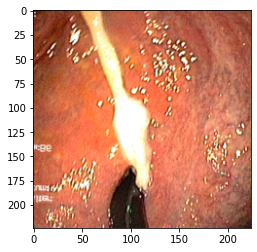

In [ ]:
# Show an image example
import matplotlib.pyplot as plt
%matplotlib inline 

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[4])

2.Preparing Train, Validation and Test data

In [ ]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed);

In [ ]:
train_size = round(len(dataset)*0.7) # 70% training set
val_size = len(dataset) - train_size # 30% testing set
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [ ]:
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


3. Set Up GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

4. Creating Model Class

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

In [ ]:
class DysplasiaModelBase(nn.Module):
    
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
       
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    

    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}      

In [ ]:
resnet50 = models.resnet50(pretrained=True)

In [ ]:
class DysplasiaResnet(DysplasiaModelBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}
    
    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):
        
        # Training Phase 
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']                     
            train_outputs.append(outputs)
            
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                       
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()                                     
            optimizer.zero_grad()                               

        
        # Validation phase
        val_results = evaluate(model, val_loader)
        
        # Save best loss
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')
        
        # print results
        model.epoch_end(epoch, train_results, val_results)
        
        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    model.load_state_dict(best_model_wts)                         # load best model
    
    return history, optimizer, best_loss

5. Train and Evaluate Model

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(DysplasiaResnet(), device)

In [ ]:
epochs = 20
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam

weight = torch.FloatTensor([0.5, 0.5]).to(device)

In [ ]:
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1], train_loss: 0.0924, train_acc: 0.9607, val_loss: 0.0182, val_acc: 0.9940
Epoch [2], train_loss: 0.0006, train_acc: 1.0000, val_loss: 0.0002, val_acc: 1.0000
Epoch [3], train_loss: 0.0002, train_acc: 1.0000, val_loss: 0.0001, val_acc: 1.0000
Epoch [4], train_loss: 0.0002, train_acc: 1.0000, val_loss: 0.0001, val_acc: 1.0000
Epoch [5], train_loss: 0.0001, train_acc: 1.0000, val_loss: 0.0001, val_acc: 1.0000
Epoch [6], train_loss: 0.0001, train_acc: 1.0000, val_loss: 0.0001, val_acc: 1.0000
Epoch [7], train_loss: 0.0001, train_acc: 1.0000, val_loss: 0.0001, val_acc: 1.0000
Epoch [8], train_loss: 0.0001, train_acc: 1.0000, val_loss: 0.0000, val_acc: 1.0000
Epoch [9], train_loss: 0.0001, train_acc: 1.0000, val_loss: 0.0000, val_acc: 1.0000
Epoch [10], train_loss: 0.0000, train_acc: 1.0000, val_loss: 0.0000, val_acc: 1.0000
Epoch [11], train_loss: 0.0000, train_acc: 1.0000, val_loss: 0.0000, val_acc: 1.0000
Epoch [12], train_loss: 0.0000, train_acc: 1.0000, val_loss: 0.0000, val_a

In [ ]:
print('Best loss is:', best_loss)

Best loss is: 1.5405777958221734e-05


In [ ]:
# Save Model
bestmodel = {'model': DysplasiaResnet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'DysplasiaResnet.pth')

In [ ]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

#model = load_checkpoint('./DysplasiaResnet.pth')

6. Accuracy and Loss Plots

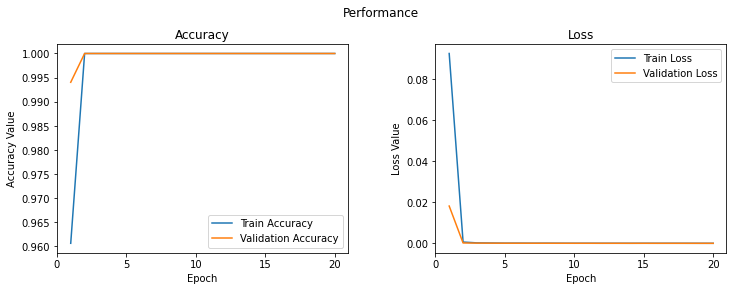

In [ ]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

7. Predicting on Test Set

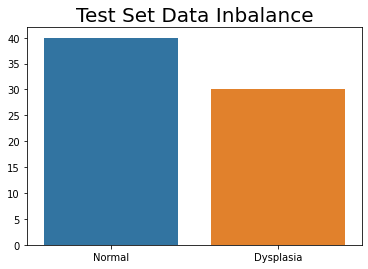

In [ ]:
# number of images for each class

test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/Normal', filename) 
                     for filename in os.listdir(data_dir+'/test/Normal')])], 
     'Dysplasia': [len([os.path.join(data_dir+'/test/Dysplasia', filename) 
                        for filename in os.listdir(data_dir+'/test/Dysplasia')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=tt.Compose([tt.Resize(255),
                                      tt.CenterCrop(224),                                                              
                                      tt.ToTensor()
                                    ]))

In [ ]:
# Evaluate test set

test_dl = DataLoader(test_dataset, batch_size=256)
test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.3790, test_acc: 0.9000


8. Model Evaluation Metrics

<Figure size 432x288 with 0 Axes>

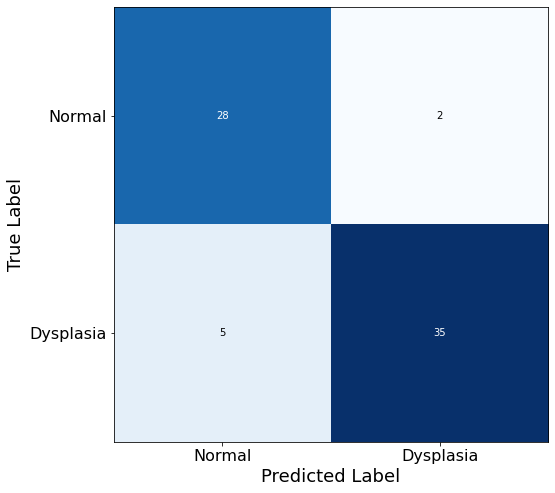

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Dysplasia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Dysplasia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.90
Recall of the model is 0.88
Precision of the model is 0.95
F1 Score of the model is 0.91
